# Introducción a la visualización de datos: Distribuciones

### OBJETIVO

- Utilizar `boxplots` para visualizar distribuciones
- Filtrar `valores atípicos` usando el `Score de Rango Intercuartílico`
- Caracterizar nuestras distribuciones usando `tablas de frecuencias`, `histogramas` y `gráficas de densidad`

## Carga general de datos

Para obtener nuestras distribuciones, utilizaremos las siguientes librerias y funciones:

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis

In [2]:
# Nos identifica los registros que se encuentran fuera del Score del IQR
def is_outlier(x):

    IQR = x.quantile(0.75) - x.quantile(0.25)
    filtro_sup = x.quantile(0.75) + (IQR * 1.5)
    filtro_inf = x.quantile(0.25) - (IQR * 1.5)
    
    return (x > filtro_sup) | (x < filtro_inf)

In [3]:
# Nos calcula la media truncada al 10% de una columna x
def trim_mean_10(x):
    return stats.trim_mean(x, 0.1)

In [4]:
# Nos calcula el percentil n de una columna x 
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    return percentile_

Vamos a realizar lo siguiente:

- Cargar los documentos que validaremos, para visualizar su `distribución` y eliminar los `outliders`
- Normalizar la fecha en formato de `ns`

In [5]:
df_PM10 = pd.read_csv('../Datasets/PM10/PM10_depurado_melt.csv', index_col=0)  #Data PM 10
df_PM25 = pd.read_csv('../Datasets/PM2.5/PM25_depurado_melt.csv', index_col=0) #Data PM 2.5

#Normalizamos fechas
df_PM10['FECHA'] = pd.to_datetime(df_PM10['FECHA'], unit='ns') 
df_PM25['FECHA'] = pd.to_datetime(df_PM25['FECHA'], unit='ns')


## Distribución de $PM_{10}$

Comenzamos generando `boxplots` por `estación` y `zona` de está partícula, para poder identificar visualmente como se encuentran `distribuidos` nuestros datos, así como los datos atípicos (`outliders`).  
Con esto, podemos complementar nuestros estimados de locación que previamente obtuvimos.

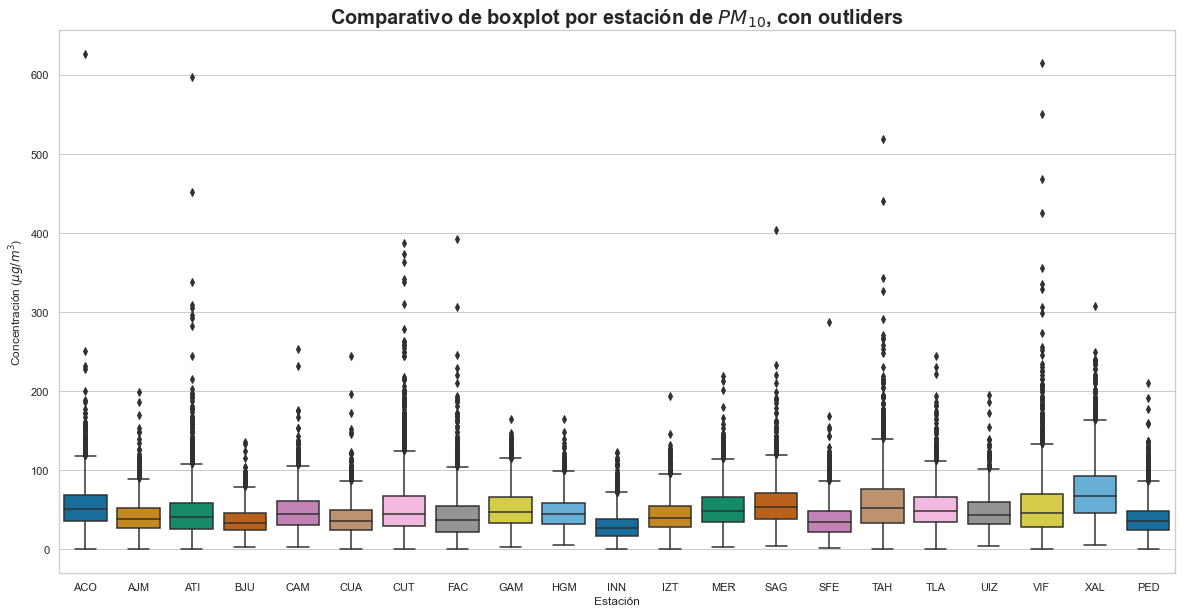

In [6]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
ax = sns.boxplot(x='station',y='measurement', data=df_PM10, palette='colorblind');
ax.set(xlabel='Estación', ylabel='Concentración ($\mu g/m^3$)');
ax.set_title('Comparativo de boxplot por estación de $PM_{10}$, con outliders', fontsize=20, fontweight='bold');

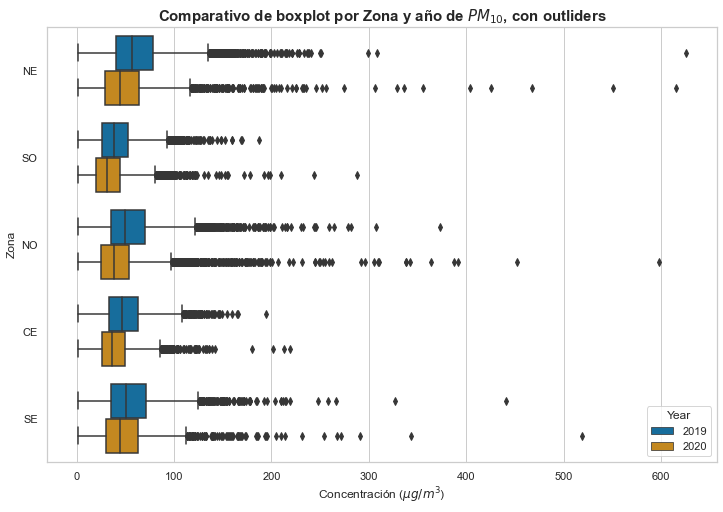

In [7]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='measurement',y='Zona', data=df_PM10, palette='colorblind', hue='Year');
ax.set(xlabel='Concentración ($\mu g/m^3$)', ylabel='Zona');
ax.set_title('Comparativo de boxplot por Zona y año de $PM_{10}$, con outliders', fontsize=15, fontweight='bold');

Después de ver nuestros boxplots, podemos confirmar visualmente que las `estaciones` que contienen los rangos más elevados `(mayores a 400` $\mu g/m^3$`)` son `ACO`, `ATI`, `SAG`, `TAH` y `VIF` (`Zonas` `NE`, `NO` y `SE`).
***
Ahora, con nuestra tabla de frecuencias, que se encuentra por intervalos de 50 $\mu g/m^3$, vemos que la `mayoría` de nuestros datos se encuentran entre `1-101` $\mu g/m^3$. Además de que `después de 151` $\mu g/m^3$ las frecuencias disminuyen drásticamente. Podemos inferir que áhí es donde se encuentran nuestros `outliders`.

In [8]:
tablas_freq_PM10 = {}
min = df_PM10['measurement'].min()
max = df_PM10['measurement'].max()
for zona in df_PM10['Zona'].unique():
  f = df_PM10[df_PM10['Zona'] == zona]
  s = pd.cut(f['measurement'], bins=range(int(min), int(max), 50))
  r = f['measurement'].groupby(s).count()
  tablas_freq_PM10[zona] = r
pd.DataFrame(tablas_freq_PM10)

,NE,SO,NO,CE,SE
measurement,,,,,
"(1, 51]",6541,13747,11180,8186,3574
"(51, 101]",5548,3417,6103,3908,2496
"(101, 151]",879,122,684,175,286
"(151, 201]",148,14,117,6,54
"(201, 251]",38,2,20,3,12
"(251, 301]",4,1,10,0,6
"(301, 351]",4,0,7,0,2
"(351, 401]",1,0,4,0,0
"(401, 451]",2,0,0,0,1


Ahora, aplicando el `Score del Rango Intercuartilico`, vamos a depurar nuestro dataset de outliders.  

Después de dicha depuración, eliminamos `1,569` registros que equivalen al `2.32%` del dataset inicial. 

In [9]:
print(f'Dataset con outliders: {df_PM10.shape[0]}')
df_PM10_no_outlier = df_PM10[~df_PM10.groupby('station').measurement.apply(is_outlier)]
print(f'Dataset sin outliders: {df_PM10_no_outlier.shape[0]}')

Dataset con outliders: 67380
Dataset sin outliders: 65811


Con nuestro dataset sin outliders, volvemos a generar boxplots con las mismas caracterísicas, para observar nuestra distribución depurada.  

Tanto a nivel estación como por zona, vemos que los boxplots ya no muestran tantos outliders como al principio. Además de que las cajas ya se encuentran más amplias al no estar tan grande el rango de nuestros datos.

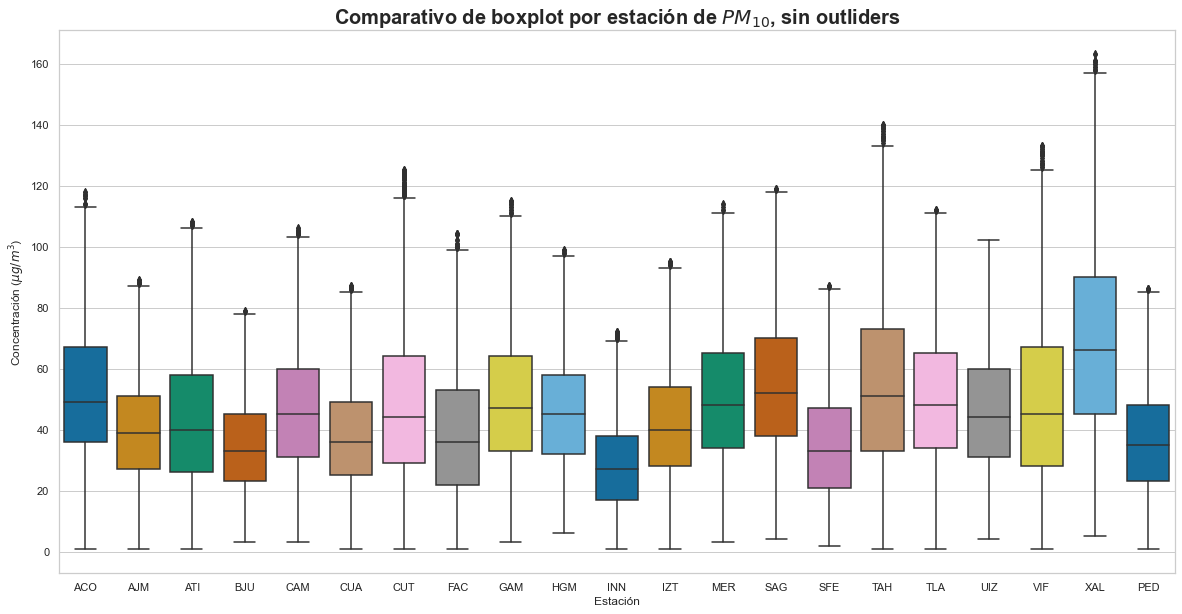

In [10]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(x='station',y='measurement', data=df_PM10_no_outlier, palette='colorblind');
ax.set(xlabel='Estación', ylabel='Concentración ($\mu g/m^3$)');
ax.set_title('Comparativo de boxplot por estación de $PM_{10}$, sin outliders', fontsize=20, fontweight='bold');

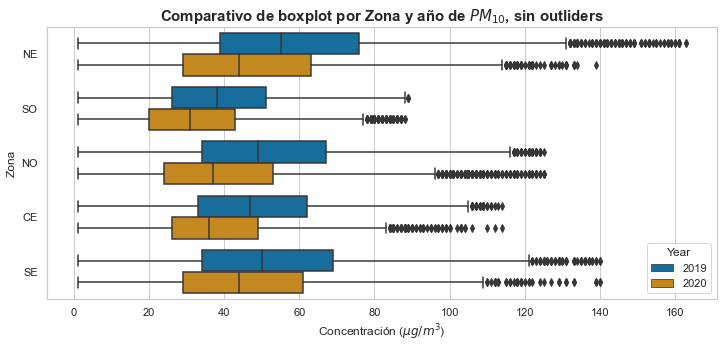

In [11]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(x='measurement',y='Zona', data=df_PM10_no_outlier, palette='colorblind', hue='Year');
ax.set(xlabel='Concentración ($\mu g/m^3$)', ylabel='Zona');
ax.set_title('Comparativo de boxplot por Zona y año de $PM_{10}$, sin outliders', fontsize=15, fontweight='bold');

También en nuestra tabla de frecuencias se aprecia que los datos no superan los `151` $\mu g/m^3$, y redujimos el intervalo a 25 $\mu g/m^3$ para apreciar que realmente nuestros datos se encuentran concentrados entre `26-76` $\mu g/m^3$

In [12]:
tablas_freq_PM10_no = {}
min = df_PM10_no_outlier['measurement'].min()
max = df_PM10_no_outlier['measurement'].max()
for zona in df_PM10_no_outlier['Zona'].unique():
  f = df_PM10_no_outlier[df_PM10_no_outlier['Zona'] == zona]
  s = pd.cut(f['measurement'], bins=range(int(min), int(max), 25))
  r = f['measurement'].groupby(s).count()
  tablas_freq_PM10_no[zona] = r
pd.DataFrame(tablas_freq_PM10_no)

,NE,SO,NO,CE,SE
measurement,,,,,
"(1, 26]",1838,5742,3924,2521,1093
"(26, 51]",4703,8005,7256,5665,2481
"(51, 76]",3743,2844,4436,3140,1802
"(76, 101]",1805,314,1667,715,694
"(101, 126]",580,0,335,52,172
"(126, 151]",133,0,0,0,50


Comparando nuestros `estimados de locación y variabilidad` en el dataset inicial y el depurado, apreciamos lo siguiente:  
- Como ya pudimos ver en nuestros boxplots y la tabla de frecuencias, nuestros `rangos` disminuyeron drásticamente, aunque siguen siendo mayores al IQR, ya que este se reajusta a los nuevos datos y continua considerando "nuevos" outliders.  
- Las `medias` también disminuyeron, reduciendo más la ya de por sí corta diferencia con la mediana. Lo que nos sigue confirmando un bajo sesgo en nuestra distribución.  
- A pesar de que disminuyó nuestra `desviación estándar`, la mayoría nuestros datos continuan dentro del `percentil 25 y 75`.

In [13]:
#Datos sin depurar
df_PM10.groupby('Zona').measurement.agg(
    media='mean',
    mediana='median',
    media_truncada=trim_mean_10,
    desv_estandar='std',
    minimo='min',
    percentile_25=percentile(0.25),
    percentile_50=percentile(0.5),
    percentile_75=percentile(0.75),
    maximo='max',
    rango=np.ptp, # max - min
    IQR=stats.iqr
)

,media,mediana,media_truncada,desv_estandar,minimo,percentile_25,percentile_50,percentile_75,maximo,rango,IQR
Zona,,,,,,,,,,,
CE,44.662785,42.0,43.026466,21.635150,1.0,29.0,42.0,57.0,219.0,218.0,28.0
NE,57.326681,52.0,53.889700,33.717891,1.0,35.0,52.0,73.0,626.0,625.0,38.0
NO,48.680533,44.0,45.538033,30.013797,1.0,29.0,44.0,62.0,598.0,597.0,33.0
SE,52.554503,47.0,49.322787,31.274101,1.0,32.0,47.0,67.0,519.0,518.0,35.0
SO,37.200543,34.0,35.399624,20.204603,1.0,23.0,34.0,48.0,288.0,287.0,25.0


In [14]:
#Datos depurados
df_PM10_no_outlier.groupby('Zona').measurement.agg(
    media='mean',
    mediana='median',
    media_truncada=trim_mean_10,
    desv_estandar='std',
    minimo='min',
    percentile_25=percentile(0.25),
    percentile_50=percentile(0.5),
    percentile_75=percentile(0.75),
    maximo='max',
    rango=np.ptp, # max - min
    IQR=stats.iqr
)

,media,mediana,media_truncada,desv_estandar,minimo,percentile_25,percentile_50,percentile_75,maximo,rango,IQR
Zona,,,,,,,,,,,
CE,43.580570,42.0,42.491681,19.734125,1.0,29.0,42.0,56.0,114.0,113.0,27.0
NE,54.412351,51.0,52.593984,27.073466,1.0,35.0,51.0,71.0,163.0,162.0,36.0
NO,45.771016,43.0,44.290880,23.461410,1.0,28.0,43.0,60.0,125.0,124.0,32.0
SE,50.024286,47.0,48.330952,25.134852,1.0,32.0,47.0,65.0,140.0,139.0,33.0
SO,35.667771,34.0,34.654568,17.400647,1.0,22.0,34.0,47.0,89.0,88.0,25.0


Generamos un `histograma` y un `grafico de densidad`, para visualizar la forma que tiene nuestra distribución de datos, por zona.  

Con esto, apreciamos que nuestros datos tienen una mayor frecuencia en el intervalo que ya nos había proporcionado la tabla de frecuencias depurada, de `26-76` $\mu g/m^3$

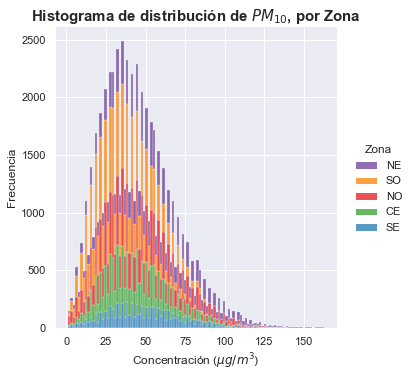

In [15]:
sns.set(style='darkgrid')
ax = sns.displot(data=df_PM10_no_outlier, x='measurement', hue='Zona', palette='Paired_r', multiple='stack');
ax.set(xlabel='Concentración ($\mu g/m^3$)', ylabel='Frecuencia');
plt.title('Histograma de distribución de $PM_{10}$, por Zona', fontsize=15, fontweight='bold');

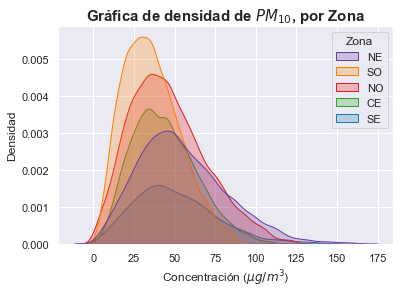

In [16]:
ax = sns.kdeplot(data=df_PM10_no_outlier, x='measurement', hue='Zona',fill=True, palette='Paired_r');
ax.set(xlabel='Concentración ($\mu g/m^3$)', ylabel='Densidad');
ax.set_title('Gráfica de densidad de $PM_{10}$, por Zona', fontsize='15', fontweight='bold');

Por último, analizamos la `curtosis` y la `asimetría` de nuestro dataset, agrupado por zona.  

- En `todas` nuestras zonas, tenemos un `sesgo positivo o a la derecha`, aunque bajo.
- En las zonas `NE` y `SE` tenemos `curtosis positiva`, lo que se traduce a una `curva leptocúrtica`.
- Las zonas `SO`, `NO` y `CE` tienen `curtosis negativa`, es decir, una `curva platocúrtica`.
- Tantos las `curtosis` como la `asimetría` de cada zona está dentro del `intervalo` de `-2 a 2`, por lo que podemos decir que estamos ante una `distribución normal`.

In [17]:
print(f'Zona | Curtosis | Asímetria')
for zona in df_PM10_no_outlier['Zona'].unique():
    print(f'---------------------------')
    print(f"{zona:4} | {round(kurtosis(df_PM10_no_outlier[df_PM10_no_outlier['Zona'] == zona]['measurement']),3):9}|{round(skew(df_PM10_no_outlier[df_PM10_no_outlier['Zona'] == zona]['measurement']),3):10}")

Zona | Curtosis | Asímetria
---------------------------
NE   |     0.382|     0.675
---------------------------
SO   |    -0.246|     0.495
---------------------------
NO   |     -0.06|     0.563
---------------------------
CE   |    -0.096|     0.503
---------------------------
SE   |     0.392|     0.673


Guardamos nuestro nuevo dataset depurado sin outliders

In [18]:
df_PM10_no_outlier.to_csv('../Datasets/PM10/PM10_depurado_melt_no_outlier.csv')

## Distribución de $PM_{2.5}$

Ahora vamos a generar `boxplots` por `estación` y `zona` de está partícula, para poder identificar visualmente como se encuentran `distribuidos` nuestros datos, así como los datos atípicos (`outliders`).  
Con esto, podemos complementar nuestros estimados de locación que previamente obtuvimos.

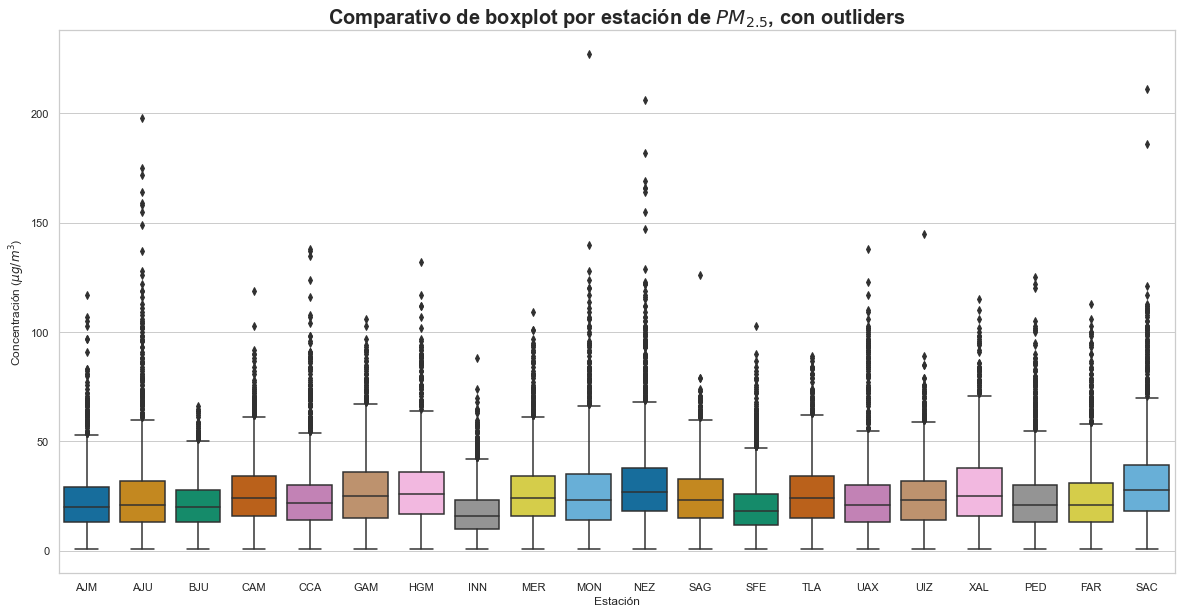

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
ax = sns.boxplot(x='station',y='measurement', data=df_PM25, palette='colorblind');
ax.set(xlabel='Estación', ylabel='Concentración ($\mu g/m^3$)');
ax.set_title('Comparativo de boxplot por estación de $PM_{2.5}$, con outliders', fontsize=20, fontweight='bold');

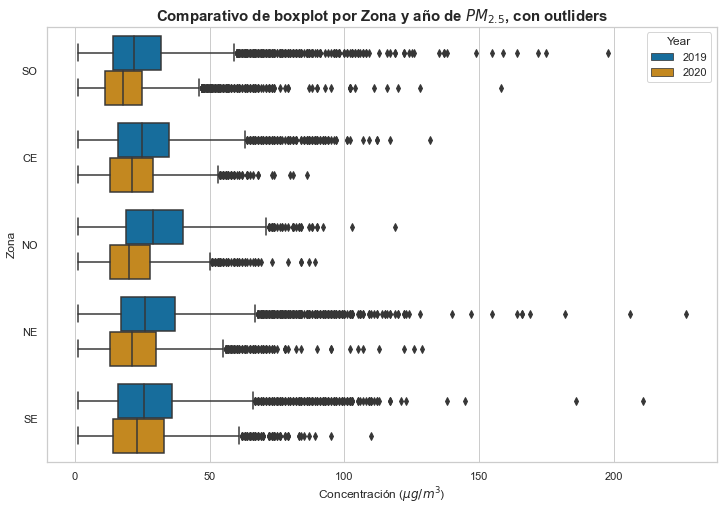

In [20]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='measurement',y='Zona', data=df_PM25, palette='colorblind', hue='Year');
ax.set(xlabel='Concentración ($\mu g/m^3$)', ylabel='Zona');
ax.set_title('Comparativo de boxplot por Zona y año de $PM_{2.5}$, con outliders', fontsize=15, fontweight='bold');

Después de ver nuestros boxplots, podemos confirmar visualmente que las `estaciones` que contienen los rangos más elevados `(mayores a 150` $\mu g/m^3$`)` son `AJU`, `NEZ`, `SAC` (`Zonas` `SO`, `NE` y `SE`).
***
Ahora, con nuestra tabla de frecuencias, que se encuentra por intervalos de 20 $\mu g/m^3$, vemos que la `mayoría` de nuestros datos se encuentran entre `1-41` $\mu g/m^3$. Además de que `después de 61` $\mu g/m^3$ las frecuencias disminuyen drásticamente. Podemos inferir que áhí es donde se encuentran nuestros `outliders`.

In [21]:
tablas_freq_PM25 = {}
min = df_PM25['measurement'].min()
max = df_PM25['measurement'].max()
for zona in df_PM25['Zona'].unique():
  f = df_PM25[df_PM25['Zona'] == zona]
  s = pd.cut(f['measurement'], bins=range(int(min), int(max), 20))
  r = f['measurement'].groupby(s).count()
  tablas_freq_PM25[zona] = r
pd.DataFrame(tablas_freq_PM25)

,SO,CE,NO,NE,SE
measurement,,,,,
"(1, 21]",11057,3589,2923,7380,4324
"(21, 41]",7288,3689,2975,7450,4459
"(41, 61]",1157,738,783,1972,1121
"(61, 81]",246,101,115,374,163
"(81, 101]",72,48,15,128,84
"(101, 121]",29,6,2,37,29
"(121, 141]",10,1,0,9,2
"(141, 161]",4,0,0,2,1
"(161, 181]",3,0,0,4,0


Ahora, aplicando el `Score del Rango Intercuartilico`, vamos a depurar nuestro dataset de outliders.  

Después de dicha depuración, eliminamos `1,643` registros que equivalen al `2.61%` del dataset inicial

In [22]:
print(f'Dataset con outliders: {df_PM25.shape[0]}')
df_PM25_no_outlier = df_PM25[~df_PM25.groupby('station').measurement.apply(is_outlier)]
print(f'Dataset sin outliders: {df_PM25_no_outlier.shape[0]}')

Dataset con outliders: 62727
Dataset sin outliders: 61084


Con nuestro dataset sin outliders, volvemos a generar boxplots con las mismas caracterísicas, para observar nuestra distribución depurada.  

Tanto a nivel estación como por zona, vemos que los boxplots ya no muestran tantos outliders como al principio. Además de que las cajas ya se encuentran más amplias al no estar tan grande el rango de nuestros datos.

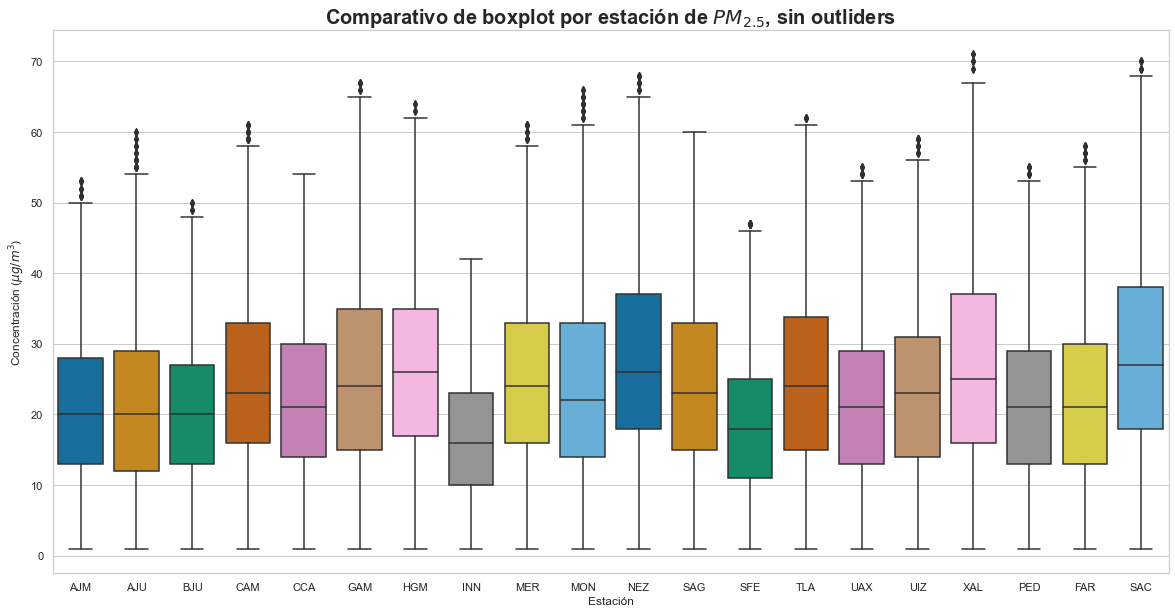

In [23]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(x='station',y='measurement', data=df_PM25_no_outlier, palette='colorblind');
ax.set(xlabel='Estación', ylabel='Concentración ($\mu g/m^3$)');
ax.set_title('Comparativo de boxplot por estación de $PM_{2.5}$, sin outliders', fontsize=20, fontweight='bold');

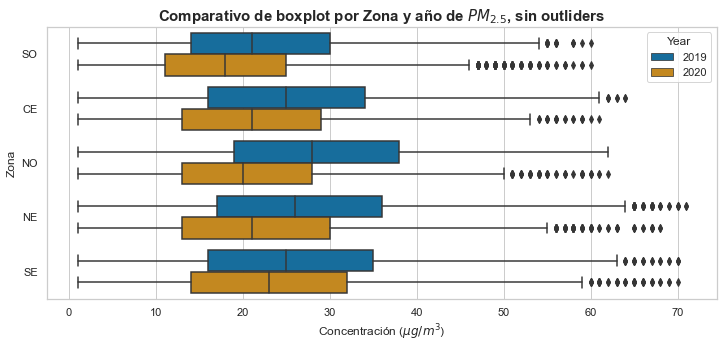

In [24]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(x='measurement',y='Zona', data=df_PM25_no_outlier, palette='colorblind', hue='Year');
ax.set(xlabel='Concentración ($\mu g/m^3$)', ylabel='Zona');
ax.set_title('Comparativo de boxplot por Zona y año de $PM_{2.5}$, sin outliders', fontsize=15, fontweight='bold');

También en nuestra tabla de frecuencias se aprecia que los datos no superan los `61` $\mu g/m^3$, y redujimos el intervalo a 10 $\mu g/m^3$ para apreciar que realmente nuestros datos se encuentran concentrados entre `11-31` $\mu g/m^3$

In [25]:
tablas_freq_PM25_no = {}
min = df_PM25_no_outlier['measurement'].min()
max = df_PM25_no_outlier['measurement'].max()
for zona in df_PM25_no_outlier['Zona'].unique():
  f = df_PM25_no_outlier[df_PM25_no_outlier['Zona'] == zona]
  s = pd.cut(f['measurement'], bins=range(int(min), int(max), 10))
  r = f['measurement'].groupby(s).count()
  tablas_freq_PM25_no[zona] = r
pd.DataFrame(tablas_freq_PM25_no)

,SO,CE,NO,NE,SE
measurement,,,,,
"(1, 11]",4234,1261,961,2600,1473
"(11, 21]",6823,2328,1962,4780,2851
"(21, 31]",5011,2334,1781,4489,2781
"(31, 41]",2277,1355,1194,2961,1678
"(41, 51]",761,532,561,1429,818
"(51, 61]",113,178,222,531,271


Comparando nuestros `estimados de locación y variabilidad` en el dataset inicial y el depurado, apreciamos lo siguiente:  
- Como ya pudimos ver en nuestros boxplots y la tabla de frecuencias, nuestros `rangos` disminuyeron drásticamente, aunque siguen siendo mayores al IQR, ya que este se reajusta a los nuevos datos y continua considerando "nuevos" outliders.  
- Las `medias` también disminuyeron, reduciendo más la ya de por sí corta diferencia con la mediana. Lo que nos sigue confirmando un bajo sesgo en nuestra distribución.  
- A pesar de que disminuyó nuestra `desviación estándar`, la mayoría nuestros datos continuan dentro del `percentil 25 y 75`.

In [26]:
#Datos sin depurar
df_PM25.groupby('Zona').measurement.agg(
    media='mean',
    mediana='median',
    media_truncada=trim_mean_10,
    desv_estandar='std',
    minimo='min',
    percentile_25=percentile(0.25),
    percentile_50=percentile(0.5),
    percentile_75=percentile(0.75),
    maximo='max',
    rango=np.ptp, # max - min
    IQR=stats.iqr
)

,media,mediana,media_truncada,desv_estandar,minimo,percentile_25,percentile_50,percentile_75,maximo,rango,IQR
Zona,,,,,,,,,,,
CE,25.144686,23.0,23.887112,14.250272,1.0,15.0,23.0,33.0,132.0,131.0,18.0
NE,26.561909,24.0,24.907112,16.271988,1.0,15.0,24.0,35.0,227.0,226.0,20.0
NO,25.856581,24.0,24.729823,14.208408,1.0,16.0,24.0,34.0,119.0,118.0,18.0
SE,26.300049,24.0,24.690991,15.862894,1.0,15.0,24.0,34.0,211.0,210.0,19.0
SO,22.101331,20.0,20.495934,14.121012,1.0,12.0,20.0,28.0,198.0,197.0,16.0


In [27]:
#Datos depurados
df_PM25_no_outlier.groupby('Zona').measurement.agg(
    media='mean',
    mediana='median',
    media_truncada=trim_mean_10,
    desv_estandar='std',
    minimo='min',
    percentile_25=percentile(0.25),
    percentile_50=percentile(0.5),
    percentile_75=percentile(0.75),
    maximo='max',
    rango=np.ptp, # max - min
    IQR=stats.iqr
)

,media,mediana,media_truncada,desv_estandar,minimo,percentile_25,percentile_50,percentile_75,maximo,rango,IQR
Zona,,,,,,,,,,,
CE,24.054940,23.0,23.410244,12.151849,1.0,15.0,23.0,32.0,64.0,63.0,17.0
NE,25.103138,24.0,24.281842,13.271203,1.0,15.0,24.0,34.0,71.0,70.0,19.0
NO,25.009204,24.0,24.299629,12.832352,1.0,15.0,24.0,33.0,62.0,61.0,18.0
SE,24.861872,24.0,24.085621,12.883238,1.0,15.0,24.0,33.0,70.0,69.0,18.0
SO,20.543597,19.0,19.818552,10.822113,1.0,12.0,19.0,27.0,60.0,59.0,15.0


Generamos un `histograma` y un `grafico de densidad`, para visualizar la forma de nuestra distribución de datos, por zona.  

Con esto, apreciamos que nuestros datos tienen una mayor frecuencia en el intervalo que ya nos había proporcionado la tabla de frecuencias depurada, de `11-31` $\mu g/m^3$

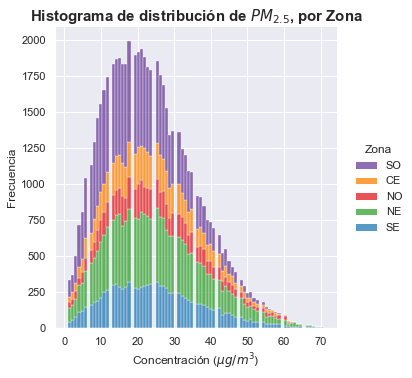

In [28]:
sns.set(style='darkgrid')
ax = sns.displot(data=df_PM25_no_outlier, x='measurement', hue='Zona', palette='Paired_r',multiple='stack');
ax.set(xlabel='Concentración ($\mu g/m^3$)', ylabel='Frecuencia');
plt.title('Histograma de distribución de $PM_{2.5}$, por Zona', fontsize=15, fontweight='bold');

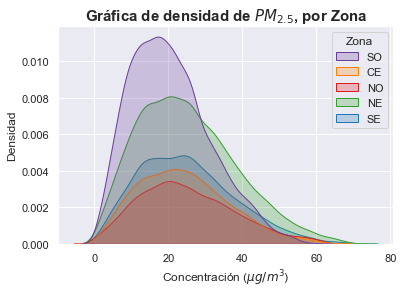

In [29]:
ax = sns.kdeplot(data=df_PM25_no_outlier, x='measurement', hue='Zona',fill=True, palette='Paired_r');
ax.set(xlabel='Concentración ($\mu g/m^3$)', ylabel='Densidad');
ax.set_title('Gráfica de densidad de $PM_{2.5}$, por Zona', fontsize='15', fontweight='bold');

Por último, analizamos la `curtosis` y la `asimetría` de nuestro dataset, agrupado por zona.  

- En `todas` nuestras zonas, tenemos un `sesgo positivo o a la derecha`, aunque bajo.
- `Todas` las zonas tienen `curtosis negativa`, es decir, una `curva platocúrtica`.
- Tantos las `curtosis` como la `asimetría` de cada zona está dentro del `intervalo` de `-2 a 2`, por lo que podemos decir que estamos ante una `distribución normal`.

In [30]:
print(f'Zona | Curtosis | Asímetria')
for zona in df_PM25_no_outlier['Zona'].unique():
    print(f'---------------------------')
    print(f"{zona:4} | {round(kurtosis(df_PM25_no_outlier[df_PM25_no_outlier['Zona'] == zona]['measurement']),3):9}|{round(skew(df_PM25_no_outlier[df_PM25_no_outlier['Zona'] == zona]['measurement']),3):10}")

Zona | Curtosis | Asímetria
---------------------------
SO   |    -0.078|     0.583
---------------------------
CE   |    -0.192|     0.471
---------------------------
NO   |     -0.27|     0.475
---------------------------
NE   |    -0.138|     0.541
---------------------------
SE   |    -0.082|     0.542


Guardamos nuestro nuevo dataset depurado sin outliders

In [31]:
df_PM25_no_outlier.to_csv('../Datasets/PM2.5/PM25_depurado_melt_no_outlier.csv')